# Scikit-learn Pipelines para PLN

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline # Esta es la clase que usaremos para desarrollar el modelo.
from sklearn.model_selection import cross_val_score
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Conjunto de datos de noticias y nombre del medio

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/giturra/JCC2023-WE/main/noticias_oct_dic_2019.tsv', sep='\t').sample(1000)

In [3]:
data

,texto,medio,fecha
991,De los polémicos comentarios de los ministros ...,El Mercurio,2019-10-22 04:38:00
7760,“Viste que la perra del vecino está embarazada...,Radio Concierto,2019-10-15 15:00:53
1844,"Director de Carabineros ordenó ""uso acotado"" d...",Cooperativa CL,2019-11-10 19:19:00
9641,“No tiene que haber exclusiones” La importanci...,La RED,2019-11-08 00:34:01
5793,Gerente regional de Essbio habla sobre ampliac...,El Rancaguino,2019-10-02 13:18:51
...,...,...,...
8902,Luis Dimas fue hospitalizado tras complicacion...,The Clinic,2019-10-08 08:59:00
2965,Corte Suprema realizó sesión extraordinaria an...,CHV,2019-11-22 11:02:00
9751,Los famosos que estarán en el nuevo espacio cu...,La RED,2019-12-19 14:26:33
5861,PDI investiga desaparición de empresario\nSus ...,El Rancaguino,2019-10-10 12:21:42


## Preprocesamiento del conjunto de datos

In [4]:
feature = data["texto"]
label = data["medio"]

In [5]:
feature_train, feature_test, label_train, label_test = train_test_split(feature, label)

## Definición del primer Pipeline

Un pipeline son una serie de pasos de transformaciones de datos con un algoritmo de entrenamiento de un modelo al final. Podemos definir todas las funciones de preprocesamiento del texto antes de ajustar el modelo. En el caso de PLN, primero vectorizamos el texto y después lo pasamos por el algoritmo de entrenamiento.

In [6]:
pipe = Pipeline(
    [ # Definimos una lista de pasos que se ejecutarán de manera serial
        ('vectorizer', CountVectorizer()), # Cada paso es una tupla que contiene el nombre del paso y la clase que se ejecutará. La clase debe exponer el método transform.
        ('classifier', RandomForestClassifier()) # Finalmente definimos el algoritmo de entrenamiento del modelo.
        ]
    )

In [7]:
pipe.fit(feature_train, label_train) # El Pipeline expone los mismos métodos que cualquier otro modelo.

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', RandomForestClassifier())])

In [8]:
predicted = pipe.predict(feature_test) # Podemos usar el mismo Pipeline para hacer inferencia sobre los datos crudos y se realizarán todos los preprocesamientos definidos.

In [9]:
print(classification_report(predicted, label_test))

                 precision    recall  f1-score   support

            CHV       0.83      0.56      0.67        36
 Cooperativa CL       0.83      0.96      0.89        26
    El Mercurio       0.22      0.45      0.29        11
  El Rancaguino       0.85      0.81      0.83        27
   La Discusión       0.54      0.54      0.54        28
      La Nación       0.37      0.52      0.43        21
         La RED       0.87      0.41      0.56        49
           MEGA       0.79      0.83      0.81        18
Radio Concierto       0.57      0.76      0.65        17
     The Clinic       0.58      0.82      0.68        17

       accuracy                           0.64       250
      macro avg       0.64      0.67      0.64       250
   weighted avg       0.70      0.64      0.65       250



## Probemos varias combinaciones

In [10]:
def normalize(text, remove_tildes=False):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower()  # Llevamos todo a minúscula
    # Reemplazamos los caracteres no alfabéticos por un espacio
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text)
    if remove_tildes:
        text = re.sub('á', 'a', text)  # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

In [11]:
stopwords_spanish = stopwords.words('spanish')

In [12]:
pipelines = [
    Pipeline([('vectorizer', CountVectorizer()), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', CountVectorizer(preprocessor=normalize)), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer(preprocessor=normalize)), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', CountVectorizer(preprocessor=normalize, stop_words=stopwords_spanish)), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer(preprocessor=normalize, stop_words=stopwords_spanish)), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', CountVectorizer(preprocessor=normalize, stop_words=stopwords_spanish, ngram_range=(1, 2))), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer(preprocessor=normalize, stop_words=stopwords_spanish, ngram_range=(1, 2))), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', CountVectorizer(preprocessor=normalize, stop_words=stopwords_spanish, ngram_range=(1, 3))), ('classifier', RandomForestClassifier())]),
    Pipeline([('vectorizer', TfidfVectorizer(preprocessor=normalize, stop_words=stopwords_spanish, ngram_range=(1, 3))), ('classifier', RandomForestClassifier())]),

]

In [13]:
results = []
for pipe in pipelines:
    results.append(
        cross_val_score(pipe, feature_train, label_train, cv=5, scoring='accuracy', n_jobs=-1)
    )

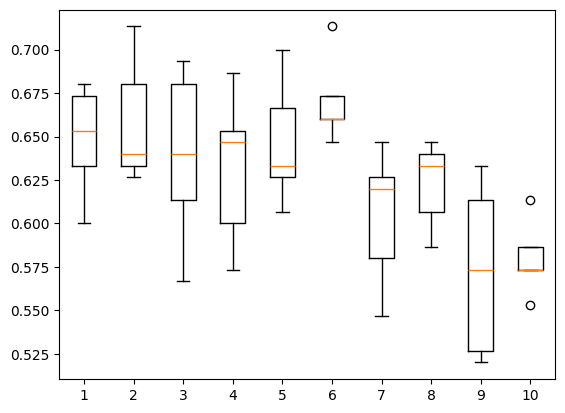

In [14]:
plt.boxplot(results)
plt.show()

---

#  Detección de Entidades Nombradas (NER)

Ahora vamos a agregar una nueva funcionalidad: extraer entidades nombradas de las noticias. Esto nos permitirá identificar personas, lugares, organizaciones, etc.

In [15]:
# Librerías para NER
import spacy
from collections import Counter, defaultdict
import numpy as np

!pip install spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 38.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## SpaCy: [es_core_news_sm](https://spacy.io/models/es#es_core_news_sm)
Pipeline español optimizado para CPU.
Componentes: tok2vec, morfologizador, analizador sintáctico, senter, ner, attribute_ruler, lematizador.

### NER Clásico
SpaCy aplica un algoritmo basado en transiciones para el
NER, que es un método que procesa el texto de forma secuencial, tomando decisiones sobre los límites y las etiquetas de las entidades en cada token.

En cada paso, el algoritmo mantiene un estado que incluye el token actual, cualquier entidad parcialmente construida y un historial de decisiones anteriores. Toma acciones de transición basándose en el estado actual y en las características extraídas de los tokens, el algoritmo elige entre un conjunto de acciones de transición predefinidas.

In [16]:
# Cargar modelo de spaCy para español
try:
    nlp = spacy.load("es_core_news_sm")
    print("Modelo de spaCy cargado exitosamente")
    print(f"Entidades reconocidas: {list(nlp.pipe_labels['ner'])}")
except OSError:
    print("Error: Instala el modelo con: python -m spacy download es_core_news_sm")

Modelo de spaCy cargado exitosamente
Entidades reconocidas: ['LOC', 'MISC', 'ORG', 'PER']


In [17]:
def extract_entities(text, nlp_model):
    """
    Extrae entidades nombradas de un texto usando spaCy

    Args:
        text (str): Texto a analizar
        nlp_model: Modelo de spaCy cargado

    Returns:
        dict: Diccionario con entidades por categoría
    """
    doc = nlp_model(text)
    entities = defaultdict(list)

    for ent in doc.ents:
        entities[ent.label_].append({
            'text': ent.text,
            'start': ent.start_char,
            'end': ent.end_char,
            'confidence': getattr(ent, 'score', 1.0)  # spaCy no siempre incluye score
        })

    return dict(entities)

def get_entity_descriptions():
    """
    Devuelve descripciones de las etiquetas de entidades en español
    """
    return {
        'PER': 'Personas',
        'LOC': 'Ubicaciones',
        'ORG': 'Organizaciones',
        'MISC': 'Misceláneas',
        'GPE': 'Entidades geopolíticas',
        'DATE': 'Fechas',
        'TIME': 'Tiempos',
        'PERCENT': 'Porcentajes',
        'MONEY': 'Dinero',
        'QUANTITY': 'Cantidades',
        'ORDINAL': 'Números ordinales',
        'CARDINAL': 'Números cardinales'
    }

print("Funciones de NER definidas")

Funciones de NER definidas


### Ejemplo de NER en una noticia

In [18]:
# Tomar una noticia de ejemplo
sample_news = data.iloc[0]['texto']
sample_medium = data.iloc[0]['medio']

print(f"MEDIO: {sample_medium}")
print(f"TEXTO: {sample_news[:500]}...")
print("\n" + "="*50)

MEDIO: El Mercurio
TEXTO: De los polémicos comentarios de los ministros al rol de Karla Rubilar: Errores y aciertos del Gobierno en la crisis
SANTIAGO.- "Errores y aciertos del Gobierno en la crisis". Así se titula una nota que El Mercurio publicó en su edición de este martes, en la que se aborda la forma en que el Ejecutivo ha enfrentado el estallido social que vive Chile, ahondando en sus aciertos y errores en medio de la crisis.
"El Ejecutivo ha enfrentado múltiples desafíos para encauzar la convulsión social y conten...



In [19]:
# Extraer entidades de la noticia
entities = extract_entities(sample_news, nlp)
entity_descriptions = get_entity_descriptions()

print("ENTIDADES ENCONTRADAS:\n")
for label, ents in entities.items():
    description = entity_descriptions.get(label, label)
    print(f"{description} ({label}):")
    for ent in ents:
        print(f"  - {ent['text']} (posición: {ent['start']}-{ent['end']})")
    print()

ENTIDADES ENCONTRADAS:

Ubicaciones (LOC):
  - Karla Rubilar (posición: 56-69)
  - Errores (posición: 71-78)
  - Gobierno (posición: 94-102)
  - Gobierno (posición: 151-159)
  - Chile (posición: 344-349)
  - Gobierno (posición: 624-632)
  - Karla Rubilar (posición: 912-925)
  - La Moneda (posición: 1042-1051)
  - Índice de Precios al Consumidor (posición: 1328-1359)
  - ministro de Economía (posición: 1508-1528)
  - Transportes (posición: 1739-1750)
  - Panel de Expertos del Transantiago (posición: 1992-2026)
  - Transportes (posición: 2436-2447)
  - Instituto Nacional (posición: 3153-3171)
  - La Moneda (posición: 4212-4221)
  - Interior (posición: 4342-4350)
  - Andrés Chadwick (posición: 4352-4367)
  - Vitacura
Minutos (posición: 4550-4566)
  - Gobierno (posición: 4685-4693)
  - Gran Santiago (posición: 6176-6189)
  - Santiago (posición: 7161-7169)
  - palas (posición: 7722-7727)
  - Empresa Metro (posición: 7778-7791)
  - Gobierno (posición: 7848-7856)
  - Cámara de Diputados (posi

## Análisis masivo de entidades en el dataset

In [20]:
# Procesar una muestra del dataset (para evitar demora)
sample_size = 100
sample_data = data.sample(n=sample_size, random_state=42)

print(f"Procesando {sample_size} noticias para análisis de entidades...")

all_entities = []
entity_stats = defaultdict(Counter)

for idx, row in sample_data.iterrows():
    try:
        entities = extract_entities(row['texto'], nlp)
        news_entities = {
            'medio': row['medio'],
            'entities': entities
        }
        all_entities.append(news_entities)

        # Contar entidades por tipo
        for label, ents in entities.items():
            entity_stats[label].update([ent['text'].lower() for ent in ents])

    except Exception as e:
        print(f"Error procesando índice {idx}: {e}")
        continue

print(f"Procesamiento completado. {len(all_entities)} noticias analizadas.")

Procesando 100 noticias para análisis de entidades...
Procesamiento completado. 100 noticias analizadas.


In [21]:
# Estadísticas generales de entidades
entity_descriptions = get_entity_descriptions()

print(" ESTADÍSTICAS DE ENTIDADES NOMBRADAS\n")
print(f"{'Tipo':<15} {'Total':<8} {'Únicas':<8} {'Top 3'}")
print("-" * 70)

for label, counter in entity_stats.items():
    description = entity_descriptions.get(label, label)
    total_count = sum(counter.values())
    unique_count = len(counter)
    top_3 = [item[0] for item in counter.most_common(3)]

    print(f"{description[:14]:<15} {total_count:<8} {unique_count:<8} {', '.join(top_3)[:40]}")

 ESTADÍSTICAS DE ENTIDADES NOMBRADAS

Tipo            Total    Únicas   Top 3
----------------------------------------------------------------------
Personas        1023     625      manifestantes, lee, también
Ubicaciones     1425     819      chile, valparaíso, concepción
Misceláneas     1012     664      october 27, october 26, october 28
Organizaciones  522      323      carabineros, indh, somoscooperativa


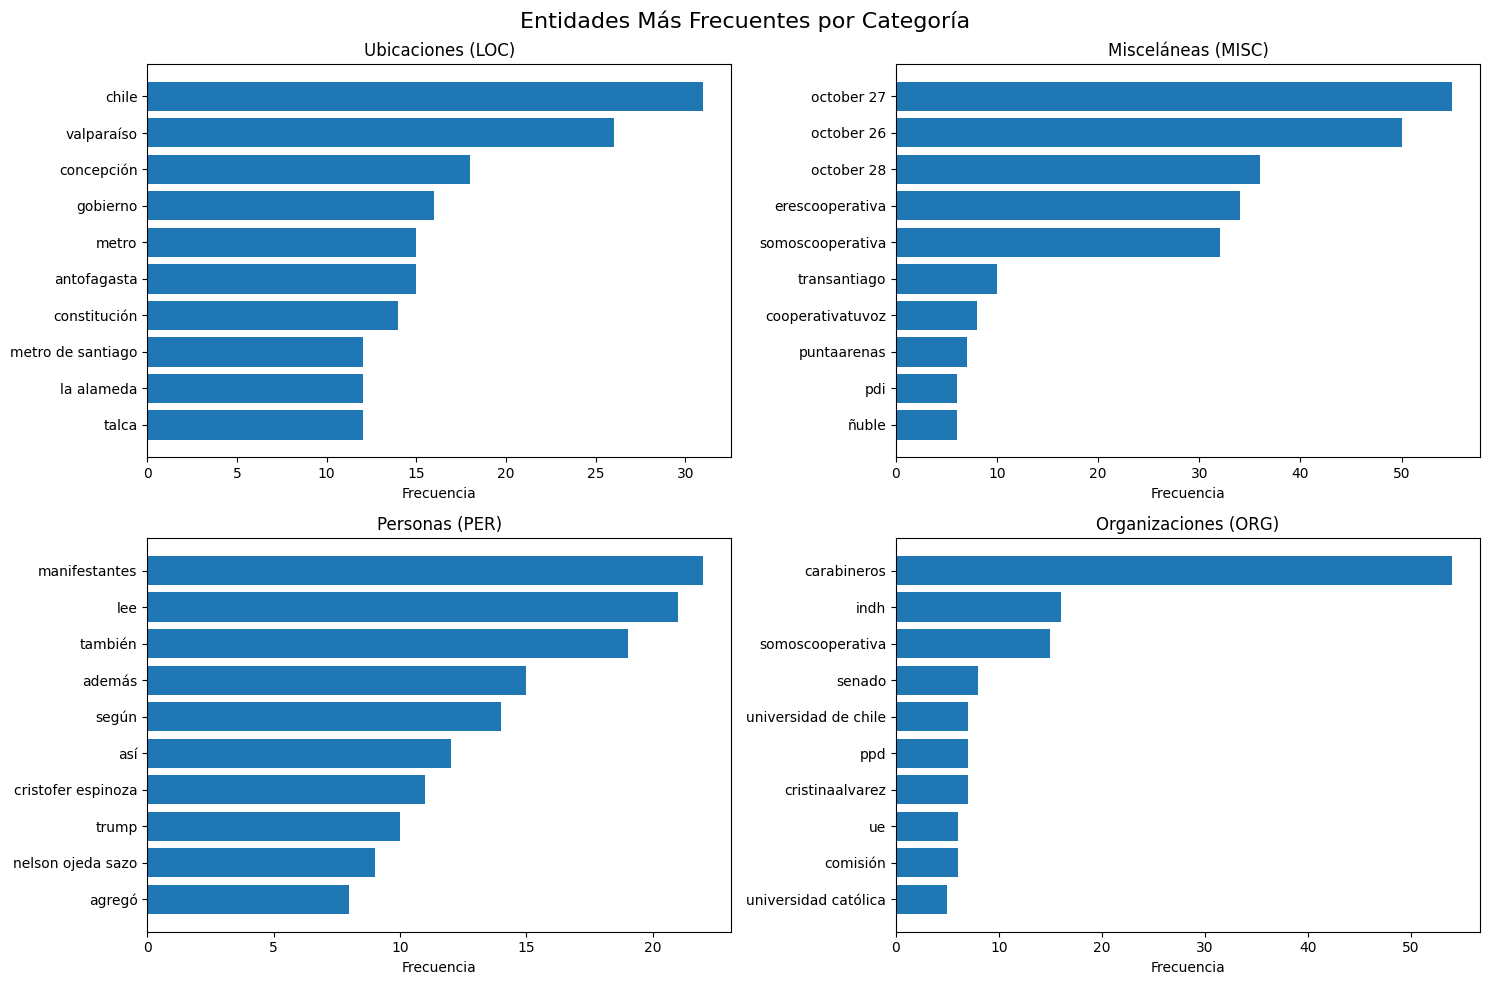

In [22]:
def plot_entity_stats(entity_stats, entity_descriptions):
    """
    Visualiza las entidades más frecuentes por categoría.

    Args:
        entity_stats (defaultdict): Diccionario con contadores de entidades por categoría.
        entity_descriptions (dict): Diccionario con descripciones de las etiquetas de entidades.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Entidades Más Frecuentes por Categoría', fontsize=16)

    # Seleccionar las 4 categorías con más entidades
    top_categories = sorted(entity_stats.keys(),
                           key=lambda x: len(entity_stats[x]),
                           reverse=True)[:4]

    for i, category in enumerate(top_categories):
        row = i // 2
        col = i % 2

        # Top 10 entidades en esta categoría
        top_entities = entity_stats[category].most_common(10)

        if top_entities:
            entities, counts = zip(*top_entities)

            axes[row, col].barh(range(len(entities)), counts)
            axes[row, col].set_yticks(range(len(entities)))
            axes[row, col].set_yticklabels([e[:20] + '...' if len(e) > 20 else e for e in entities])
            axes[row, col].set_xlabel('Frecuencia')

            description = entity_descriptions.get(category, category)
            axes[row, col].set_title(f'{description} ({category})')
            axes[row, col].invert_yaxis()

    plt.tight_layout()
    plt.show()

# Visualizar las entidades más frecuentes usando la nueva función
plot_entity_stats(entity_stats, entity_descriptions)

## NER con Hugging Face Transformers

In [41]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from collections import defaultdict
import torch

from transformers import pipeline, AutoTokenizer
from collections import defaultdict
import torch

def load_transformer_ner_pipeline():
    """
    Carga un pipeline de NER usando transformers
    """
    model_id = "mrm8488/bert-spanish-cased-finetuned-ner"

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.model_max_length = 512

    device = 0 if torch.cuda.is_available() else -1

    ner_pipeline = pipeline(
        "ner",
        model=model_id,
        tokenizer=tokenizer,
        aggregation_strategy="simple",  # agrupa subtokens
        device=device,
    )

    return ner_pipeline

transformer_ner = load_transformer_ner_pipeline()

Some weights of the model checkpoint at mrm8488/bert-spanish-cased-finetuned-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [46]:
def extract_entities_transformers(text, ner_pipeline, confidence_threshold=0.8, max_chars=2000):
    """
    Extrae entidades usando transformers con filtrado por confianza.
    Recorta el texto a max_chars para evitar problemas de longitud.
    """
    try:
        # Recortar texto si es muy largo
        if len(text) > max_chars:
            text = text[:max_chars]

        # Obtener predicciones (SIN truncation=)
        predictions = ner_pipeline(text)

        entities = defaultdict(list)

        for pred in predictions:
            score = pred.get("score", 0)
            if score >= confidence_threshold:
                label = pred.get("entity_group", pred.get("entity", "MISC"))
                label = label.replace("B-", "").replace("I-", "")

                entities[label].append({
                    "text": pred["word"],
                    "start": pred["start"],
                    "end": pred["end"],
                    "confidence": score,
                    "source": "transformers",
                })

        return dict(entities)

    except Exception as e:
        print(f"Error en extracción con transformers: {e}")
        return {}

def get_entity_descriptions():
    """
    Mapeo de etiquetas de entidades a descripciones en español
    """
    return {
        'PER': 'Personas',
        'PERSON': 'Personas',
        'LOC': 'Ubicaciones',
        'LOCATION': 'Ubicaciones',
        'ORG': 'Organizaciones',
        'ORGANIZATION': 'Organizaciones',
        'MISC': 'Misceláneas',
        'MISCELLANEOUS': 'Misceláneas'
    }

print("Funciones de NER con Transformers definidas")

Funciones de NER con Transformers definidas


## Ejemplo de NER en una noticia

In [47]:
# Tomar una noticia de ejemplo
sample_news = data.iloc[0]['texto']
sample_medium = data.iloc[0]['medio']

print(f"MEDIO: {sample_medium}")
print(f"TEXTO: {sample_news[:500]}...")
print("\n" + "="*50)

MEDIO: El Mercurio
TEXTO: De los polémicos comentarios de los ministros al rol de Karla Rubilar: Errores y aciertos del Gobierno en la crisis
SANTIAGO.- "Errores y aciertos del Gobierno en la crisis". Así se titula una nota que El Mercurio publicó en su edición de este martes, en la que se aborda la forma en que el Ejecutivo ha enfrentado el estallido social que vive Chile, ahondando en sus aciertos y errores en medio de la crisis.
"El Ejecutivo ha enfrentado múltiples desafíos para encauzar la convulsión social y conten...



In [48]:
# Extraer entidades de la noticia
entities = extract_entities_transformers(sample_news, transformer_ner)
entity_descriptions = get_entity_descriptions()

print("ENTIDADES ENCONTRADAS:\n")
for label, ents in entities.items():
    description = entity_descriptions.get(label, label)
    print(f"{description} ({label}):")
    for ent in ents:
        print(f"  - {ent['text']} (posición: {ent['start']}-{ent['end']})")
    print()

ENTIDADES ENCONTRADAS:

Personas (PER):
  - Karla Rubilar (posición: 56-69)
  - Gabriel Pardo (posición: 583-596)
  - Manda (posición: 797-802)
  - Karla Rubilar (posición: 912-925)
  - Felipe Larraín (posición: 1277-1291)
  - Juan Andrés Fontaine (posición: 1530-1550)
  - Gloria Hutt (posición: 1752-1763)

Organizaciones (ORG):
  - Gobierno (posición: 94-102)
  - Gobierno (posición: 151-159)
  - El Mercurio (posición: 202-213)
  - Ejecutivo (posición: 291-300)
  - Ejecutivo (posición: 414-423)
  - Gobierno (posición: 624-632)
  - Panel de (posición: 1992-2000)

Ubicaciones (LOC):
  - SAN (posición: 116-119)
  - Chile (posición: 344-349)
  - La Moneda (posición: 1042-1051)

Misceláneas (MISC):
  - Hacienda (posición: 1267-1275)
  - Índice de Precios al Consumidor (posición: 1328-1359)
  - IPC (posición: 1361-1364)
  - Economía (posición: 1520-1528)
  - Transportes (posición: 1739-1750)



In [49]:
# Procesar una muestra del dataset (para evitar demora)
sample_size = 100
sample_data = data.sample(n=sample_size, random_state=42)

print(f"Procesando {sample_size} noticias para análisis de entidades...")

all_entities = []
entity_stats = defaultdict(Counter)

for idx, row in sample_data.iterrows():
    try:
        entities = extract_entities_transformers(row['texto'], transformer_ner)
        news_entities = {
            'medio': row['medio'],
            'entities': entities
        }
        all_entities.append(news_entities)

        # Contar entidades por tipo
        for label, ents in entities.items():
            entity_stats[label].update([ent['text'].lower() for ent in ents])

    except Exception as e:
        print(f"Error procesando índice {idx}: {e}")
        continue

print(f"Procesamiento completado. {len(all_entities)} noticias analizadas.")

Procesando 100 noticias para análisis de entidades...
Procesamiento completado. 100 noticias analizadas.


In [50]:
# Estadísticas generales de entidades
entity_descriptions = get_entity_descriptions()

print(" ESTADÍSTICAS DE ENTIDADES NOMBRADAS\n")
print(f"{'Tipo':<15} {'Total':<8} {'Únicas':<8} {'Top 3'}")
print("-" * 70)

for label, counter in entity_stats.items():
    description = entity_descriptions.get(label, label)
    total_count = sum(counter.values())
    unique_count = len(counter)
    top_3 = [item[0] for item in counter.most_common(3)]

    print(f"{description[:14]:<15} {total_count:<8} {unique_count:<8} {', '.join(top_3)[:40]}")

 ESTADÍSTICAS DE ENTIDADES NOMBRADAS

Tipo            Total    Únicas   Top 3
----------------------------------------------------------------------
Ubicaciones     390      243      chile, valparaíso, santiago
Misceláneas     282      211      constitución, " top gun ", bre
Personas        384      299      tru, donald trump, alex
Organizaciones  529      319      gobierno, cara, pdi


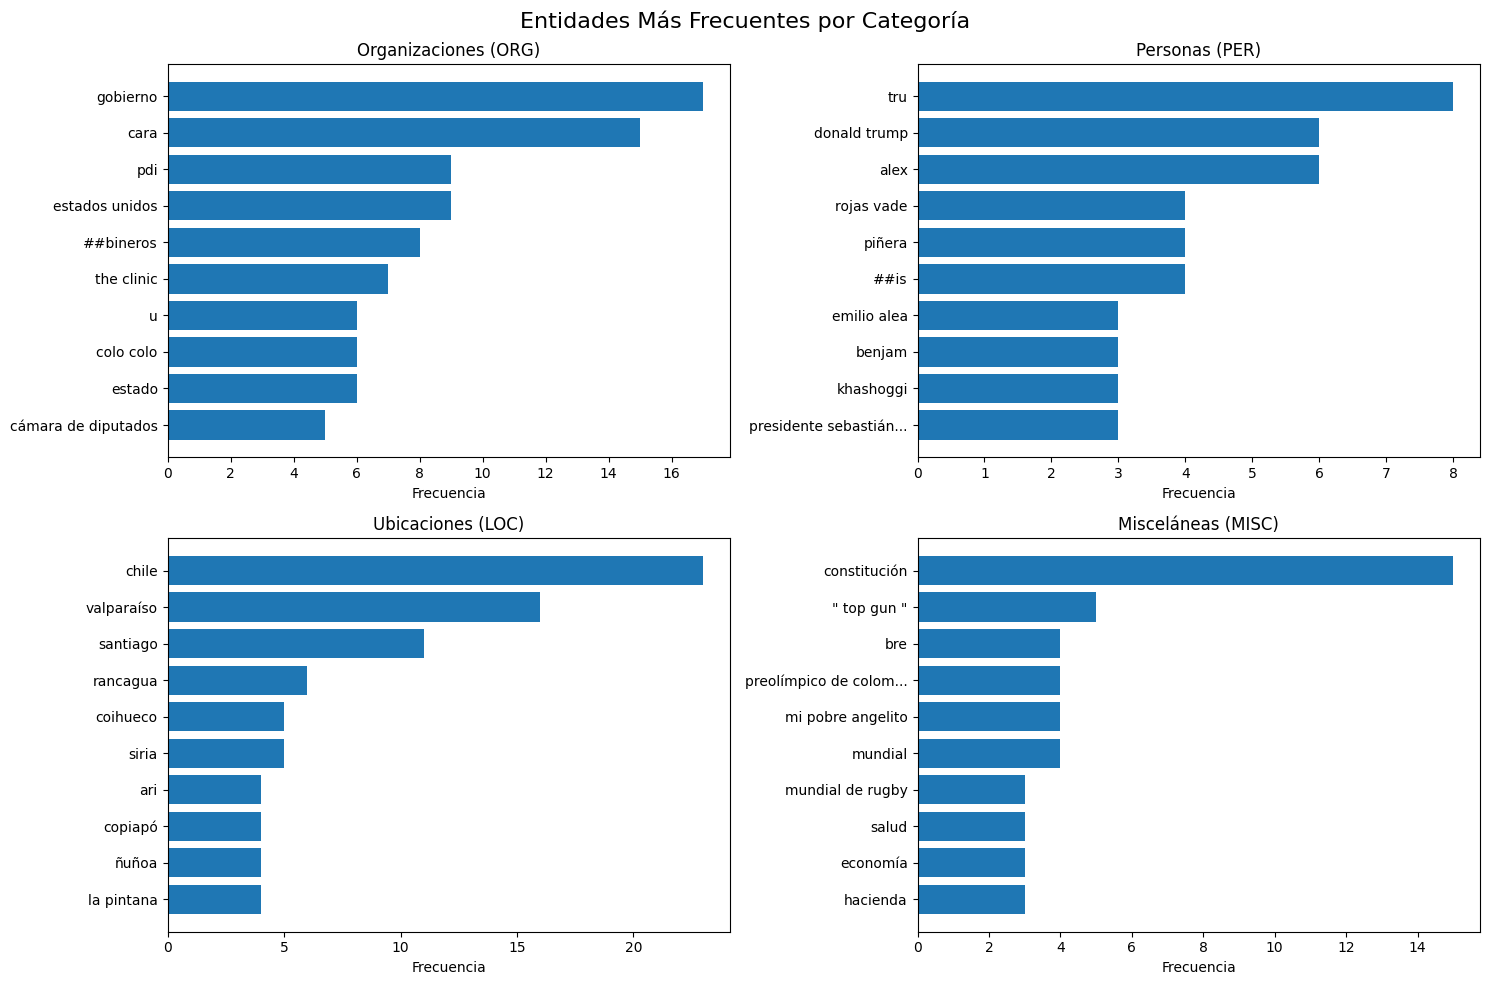

In [51]:
# Visualizar las entidades más frecuentes usando la nueva función
plot_entity_stats(entity_stats, entity_descriptions)